In [1]:
import random
import torch


words = open('names.txt', 'r').read().splitlines()
words = sorted(list(set(words))) # set cause uncontrollable randomness， sorted for reproducibility
max_len = max(len(w) for w in words)
random.seed(42)
random.shuffle(words)

chs = list(set(''.join(words + ['.']))) # add special token
chs = sorted(chs, reverse=False)
stoi = {ch: i for i, ch in enumerate(chs)}
itos = {i: ch for i, ch in enumerate(chs)}

# predict next token use previous tokens
vocab_size = len(chs)
block_size = max_len + 1
X, Y = [], []

for w in words:
    x = torch.zeros(max_len + 1, dtype=torch.long)
    y = torch.zeros(max_len + 1, dtype=torch.long)
    x[1:1+len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[:len(w)] = torch.tensor([stoi[ch] for ch in w])
    y[len(w)+1:] = -1 # mask the loss at the inactive locations
    X.append(x)
    Y.append(y)

X = torch.stack(X)
Y = torch.stack(Y)
n1, n2  = int(0.8 * len(X)), int(0.9 * len(X))

X_train, X_val, X_test = X.tensor_split([n1, n2])
Y_train, Y_val, Y_test = Y.tensor_split([n1, n2])

show = 20
for x, y in zip(X_train[:show], Y_train[:show]):
    sx = ''.join(itos[i.item()] for i in x)
    sy = ''.join(itos[i.item()] for i in y if i.item() != -1)
    print(f'{sx} -> {sy}')

X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape


.aukai.......... -> aukai.
.ellanore....... -> ellanore.
.liem........... -> liem.
.aquarius....... -> aquarius.
.joangel........ -> joangel.
.wryn........... -> wryn.
.isabela........ -> isabela.
.astryd......... -> astryd.
.maleik......... -> maleik.
.emerick........ -> emerick.
.natasha........ -> natasha.
.kasandra....... -> kasandra.
.aevin.......... -> aevin.
.brason......... -> brason.
.naiara......... -> naiara.
.alanna......... -> alanna.
.raunak......... -> raunak.
.gohan.......... -> gohan.
.ivie........... -> ivie.
.alandis........ -> alandis.


(torch.Size([23595, 16]),
 torch.Size([2949, 16]),
 torch.Size([2950, 16]),
 torch.Size([23595, 16]),
 torch.Size([2949, 16]),
 torch.Size([2950, 16]))

# move to manual backprop

In [2]:
from dataclasses import dataclass
import torch.nn as nn
import torch.nn.functional as F
# manual backprop
from tiny_torch import *

@dataclass
class ModelConfig:
    block_size: int = block_size # length of the input sequences of integers
    vocab_size: int = vocab_size # the input integers are in range [0 .. vocab_size -1]
    # parameters below control the sizes of each model slightly differently
    n_layer: int = 4
    n_embd: int = 64
    n_embd2: int = 64
    n_head: int = 4
    dtype: torch.dtype = torch.float64

## trainer

In [3]:
def train_compare(model, model_t, lr=0.1, n_steps=100, eval_every=10, bs=32):
    loss_fn = CrossEntropyLoss3d()
    # train
    torch.manual_seed(42)
    for  step in range(n_steps):
        idx = torch.randint(0, X_train.shape[0], (bs,))
        x, y = X_train[idx], Y_train[idx]

        # --- torch ---
        # forward
        logits_t = model_t(x)
        loss_t = F.cross_entropy(logits_t.view(-1, logits_t.size(-1)), y.view(-1), ignore_index=-1)
        # backward
        loss_t.backward()
        # update
        for p_t in model_t.parameters():
            p_t.data -= lr * p_t.grad
            p_t.grad = None
        # --- manual ---
        # forward
        logits = model(x)
        loss = loss_fn(logits, y)
        # backward
        dlogits = loss_fn.backward()
        model.backward(dlogits)
        # update
        for p, g in zip(model.parameters(), model.grads()):
            p.data -= lr * g
        
        
        # eval
        if step % eval_every == 0:
            x, y = X_val, Y_val
            with torch.no_grad():
                logits_t = model_t(x)
                val_loss_t = F.cross_entropy(logits_t.view(-1, logits_t.size(-1)), y.view(-1), ignore_index=-1)
            logits = model(x)
            val_loss = loss_fn(logits, y)
            print(f'step {step:<8} || Train   || {loss.item():.15f} || Val   || {val_loss.item():.15f}')
            print(f'              || Train_t || {loss_t.item():.15f} || Val_t || {val_loss_t.item():.15f}')

## mlp

In [53]:
class MLP(Module):
    """
    Adapted from https://github.com/karpathy/makemore

    Reference:
    Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = Embedding(config.vocab_size + 1, config.n_embd, dtype=config.dtype) # token embeddings table
        # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
        # before the beginning of the input sequence
        self.mlp = Sequential([
            Linear(self.block_size * config.n_embd, config.n_embd2, dtype=config.dtype),
            Tanh(),
            Linear(config.n_embd2, self.vocab_size, dtype=config.dtype)
        ])
        self.mlp[-1].weight.data *= 0.1
        self.mlp[-1].bias.data *= 0.01
        n_params = sum(p.numel() for p in self.parameters())
        print("number of mlp parameters: %d" % (n_params,))
        self.config = config
    
    def parameters(self):
        return list(self.wte.parameters()) + list(self.mlp.parameters())
    
    def grads(self):
        return list(self.wte.grads()) + list(self.mlp.grads())

    def get_block_size(self):
        return self.block_size

    def __call__(self, idx, targets=None):

        # gather the word embeddings of the previous 3 words
        idx_buf = []
        embs = []
        for k in range(self.block_size):
            tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
            idx_buf.append(idx.unsqueeze(-1))
            embs.append(tok_emb)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size # special <BLANK> token

        # concat all of the embeddings together and pass through an MLP
        x = torch.cat(embs, -1) # (b, t, n_embd * block_size)
        logits = self.mlp(x)

        # backward buffer
        self.idx_buf = torch.cat(idx_buf, -1) # (b, t, t)


        return logits
    
    def backward(self, grad):
        grad = self.mlp.backward(grad)
        # mlp backprop to wte
        b, t, _ = grad.shape # (b, t, n_embd * block_size)
        grad = grad.view(b * t * self.config.block_size, self.config.n_embd) # (b*t*block_size, n_embd)
        wte_weight = self.wte.weight
        wte_grad = torch.zeros_like(wte_weight)
        wte_grad.index_add_(dim=0, index=self.idx_buf.view(-1), source=grad)
        self.wte.weight_grad = wte_grad


In [54]:
class MLPtorch(nn.Module):
    """
    takes the previous block_size tokens, encodes them with a lookup table,
    concatenates the vectors and predicts the next token with an MLP.

    Reference:
    Bengio et al. 2003 https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf
    """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.wte = nn.Embedding(config.vocab_size + 1, config.n_embd) # token embeddings table
        # +1 in the line above for a special <BLANK> token that gets inserted if encoding a token
        # before the beginning of the input sequence
        self.mlp = nn.Sequential(
            nn.Linear(self.block_size * config.n_embd, config.n_embd2),
            nn.Tanh(),
            nn.Linear(config.n_embd2, self.vocab_size)
        )
        self.mlp[-1].weight.data *= 0.1
        self.mlp[-1].bias.data *= 0.01
        n_params = sum(p.numel() for p in self.parameters())
        print("number of mlp parameters: %d" % (n_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx, targets=None):

        # gather the word embeddings of the previous 3 words
        embs = []
        for k in range(self.block_size):
            tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
            idx = torch.roll(idx, 1, 1)
            idx[:, 0] = self.vocab_size # special <BLANK> token
            embs.append(tok_emb)

        # concat all of the embeddings together and pass through an MLP
        x = torch.cat(embs, -1) # (b, t, n_embd * block_size)
        logits = self.mlp(x)

        return logits


In [55]:
config = ModelConfig(n_embd=8, n_embd2=24)
# models
torch.manual_seed(42)
model_mlp = MLP(config)
model_mlp_t = MLPtorch(config)
# copy weights
model_mlp_t.wte.weight.data = model_mlp.wte.weight.data.clone()
for i, (p_t, p) in enumerate(zip(model_mlp_t.mlp.parameters(), model_mlp.mlp.parameters())):
    if p.dim() == 2:
        p_t.data = p.data.clone().T # linear layer weight
    else:
        p_t.data = p.data.clone()


train_compare(model_mlp, model_mlp_t)

number of mlp parameters: 3995
number of mlp parameters: 3995
step 0        || Train   || 3.297640663881704 || Val   || 3.267504153916392
              || Train_t || 3.297640663881704 || Val_t || 3.267504153916391
step 10       || Train   || 3.024899204673497 || Val   || 3.022521506732622
              || Train_t || 3.024899204673497 || Val_t || 3.022521506732622
step 20       || Train   || 2.910541702548877 || Val   || 2.903174425168292
              || Train_t || 2.910541702548878 || Val_t || 2.903174425168292
step 30       || Train   || 2.862459630906429 || Val   || 2.846881946272189
              || Train_t || 2.862459630906429 || Val_t || 2.846881946272189
step 40       || Train   || 2.788301334625511 || Val   || 2.806272830481473
              || Train_t || 2.788301334625510 || Val_t || 2.806272830481473
step 50       || Train   || 2.816853557882264 || Val   || 2.773501814770002
              || Train_t || 2.816853557882264 || Val_t || 2.773501814770002
step 60       || Train   |

## rnn

In [49]:
class RNN(Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.n_embd = config.n_embd
        self.n_embd2 = config.n_embd2
        self.start = torch.zeros(1, config.n_embd2, dtype=config.dtype) # the starting hidden state
        self.wte = Embedding(config.vocab_size, config.n_embd, dtype=config.dtype) # token embeddings table
        self.Cw = Linear(config.n_embd + config.n_embd2, config.n_embd2, dtype=config.dtype) # rnn cell weight
        self.lm_head = Linear(config.n_embd2, self.vocab_size, dtype=config.dtype)
        self.lm_head.weight.data *= 0.1
        num_params = sum(p.numel() for p in self.parameters())
        print("number of rnn parameters: %d" % (num_params,))
        # grads
        self.start_grad = None
    
    def parameters(self):
        return [self.start] + list(self.wte.parameters()) + list(self.Cw.parameters()) + list(self.lm_head.parameters())
    
    def grads(self):
        return [self.start_grad] + list(self.wte.grads()) + list(self.Cw.grads()) + list(self.lm_head.grads())

    def get_block_size(self):
        return self.block_size

    def __call__(self, x):
        b, t = x.size()
        emb = self.wte(x) # (b, t, n_embd)
        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        emb_cat_hprevs = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            emb_i_cat_hprev = torch.cat([xt, hprev], dim=1)
            # --- rnn cell ---
            hi = self.Cw(emb_i_cat_hprev)
            hi = hi.tanh()
            # --------------
            hprev = hi
            hiddens.append(hi)
            emb_cat_hprevs.append(emb_i_cat_hprev)
        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)
        # backward buffer
        self.hidden = hidden
        self.emb_cat_hprevs = emb_cat_hprevs
        return logits

    def backward(self, grad):
        hidden, emb_cat_hprevs = self.hidden, self.emb_cat_hprevs
        t = hidden.size(1)
        dhidden = self.lm_head.backward(grad)
        # logits grad to start, wte, Cw grad
        dembs = []
        dCw, dhprev = 0., 0.
        if self.Cw.bias is not None:
            dCw_bias = 0.
        for i in range(t-1, -1, -1):
            # hidden state grad, emb grad
            dhi = dhidden[:, i, :] + dhprev # grad from logits + grad from prev hidden state
            hi = hidden[:, i, :]
            dhi = (1 - hi**2) * dhi # grad of tanh
            demb_i_cat_dhi = dhi @ self.Cw.weight.T
            demb_i, dhprev = demb_i_cat_dhi.tensor_split([self.n_embd,], dim=1)
            dembs.append(demb_i)
            # cell weight grad
            emb_i_cat_hprev = emb_cat_hprevs[i]
            dCw += emb_i_cat_hprev.T @ dhi
            if self.Cw.bias is not None:
                dCw_bias += dhi.sum(dim=0)
        dstart = dhprev.sum(dim=0, keepdim=True)
        demb = torch.stack(dembs[::-1], 1)
        self.wte.backward(demb)
        self.start_grad = dstart
        self.Cw.weight_grad = dCw
        if self.Cw.bias is not None:
            self.Cw.bias_grad = dCw_bias

In [50]:
class RNNtorch(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.n_embd = config.n_embd
        self.n_embd2 = config.n_embd2
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        self.Cw = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)
        self.lm_head.weight.data *= 0.1
        num_params = sum(p.numel() for p in self.parameters())
        print("number of rnn parameters: %d" % (num_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx):
        b, t = idx.size()

        # embed all the integers up front and all at once for efficiency
        emb = self.wte(idx) # (b, t, n_embd)

        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.T.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            xh = torch.cat([xt, hprev], dim=1)
            ht = (self.Cw(xh)).tanh()
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        return logits

In [51]:
config = ModelConfig(n_embd=8, n_embd2=44)
# models
torch.manual_seed(42)
model_rnn = RNN(config)
model_rnn_t = RNNtorch(config)
# copy weights
model_rnn_t.wte.weight.data = model_rnn.wte.weight.data.clone()
for i, (p_t, p) in enumerate(zip(model_rnn_t.parameters(), model_rnn.parameters())):
    if p.dim() == 2 and i != 1: # skip the embedding layer
        p_t.data = p.data.clone().T # linear layer weight
    else:
        p_t.data = p.data.clone()

train_compare(model_rnn, model_rnn_t)

number of rnn parameters: 3807
number of rnn parameters: 3807
step 0        || Train   || 3.294839983578878 || Val   || 3.286344415679592
              || Train_t || 3.294839983578878 || Val_t || 3.286344415679593
step 10       || Train   || 3.227770821522568 || Val   || 3.219490323898836
              || Train_t || 3.227770821522568 || Val_t || 3.219490323898836
step 20       || Train   || 3.161388113574983 || Val   || 3.154835365687406
              || Train_t || 3.161388113574983 || Val_t || 3.154835365687406
step 30       || Train   || 3.092995482586020 || Val   || 3.081645231631132
              || Train_t || 3.092995482586020 || Val_t || 3.081645231631132
step 40       || Train   || 2.984496074098745 || Val   || 2.977521187897202
              || Train_t || 2.984496074098745 || Val_t || 2.977521187897202
step 50       || Train   || 2.896630851098716 || Val   || 2.839125178939733
              || Train_t || 2.896630851098716 || Val_t || 2.839125178939733
step 60       || Train   |

## gru

In [45]:
class GRU(Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.n_embd = config.n_embd
        self.n_embd2 = config.n_embd2
        self.start = torch.zeros(1, config.n_embd2, dtype=config.dtype) # the starting hidden state
        self.wte = Embedding(config.vocab_size, config.n_embd, dtype=config.dtype) # token embeddings table
        self.Cr = Linear(config.n_embd + config.n_embd2, config.n_embd2, dtype=config.dtype)
        self.Cbar = Linear(config.n_embd + config.n_embd2, config.n_embd2, dtype=config.dtype)
        self.Cz = Linear(config.n_embd + config.n_embd2, config.n_embd2, dtype=config.dtype)
        self.lm_head = Linear(config.n_embd2, self.vocab_size, dtype=config.dtype)
        self.lm_head.weight.data *= 0.1
        num_params = sum(p.numel() for p in self.parameters())
        print("number of gru parameters: %d" % (num_params,))
        # grads
        self.start_grad = None
    
    def parameters(self):
        return [self.start] + list(self.wte.parameters()) + list(self.Cr.parameters()) + list(self.Cbar.parameters()) + list(self.Cz.parameters()) + list(self.lm_head.parameters())
    
    def grads(self):
        return [self.start_grad] + list(self.wte.grads()) + list(self.Cr.grads()) + list(self.Cbar.grads()) + list(self.Cz.grads()) + list(self.lm_head.grads())

    def get_block_size(self):
        return self.block_size

    def __call__(self, x):
        b, t = x.size()
        emb = self.wte(x) # (b, t, n_embd)
        # sequentially iterate over the inputs and update the RNN state each tick
        hprev = self.start.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        emb_cat_hprevs, emb_cat_hprev_resets, hprevs, hbars, zs, rs = [], [], [], [], [], []
        for i in range(t):
            emb_i = emb[:, i, :] # (b, n_embd)
            # --- gru cell ---
            emb_i_cat_hprev = torch.cat([emb_i, hprev], dim=1)
            ri = self.Cr(emb_i_cat_hprev)
            ri = ri.sigmoid()
            hprev_reset = ri * hprev
            emb_i_cat_hprev_reset = torch.cat([emb_i, hprev_reset], dim=1)
            hbar = self.Cbar(emb_i_cat_hprev_reset)
            hbar = hbar.tanh()
            zi = self.Cz(emb_i_cat_hprev)
            zi = zi.sigmoid()
            hi = (1 - zi) * hprev + zi * hbar
            # backward buffer
            hiddens.append(hi)
            emb_cat_hprevs.append(emb_i_cat_hprev)
            emb_cat_hprev_resets.append(emb_i_cat_hprev_reset)
            hprevs.append(hprev)
            hbars.append(hbar)
            zs.append(zi)
            rs.append(ri)
            # update hprev
            hprev = hi
        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)
        # backward buffer
        self.hidden = hidden
        self.emb_cat_hprevs = emb_cat_hprevs
        self.emb_cat_hprev_resets = emb_cat_hprev_resets
        self.hprevs = hprevs
        self.hbars = hbars
        self.zs = zs
        self.rs = rs
        return logits

    def backward(self, dlogits):
        hidden, emb_cat_hprevs, emb_cat_hprev_resets, hprevs, hbars, zs, rs = self.hidden, self.emb_cat_hprevs, self.emb_cat_hprev_resets, self.hprevs, self.hbars, self.zs, self.rs
        t = hidden.size(1)
        dhidden = self.lm_head.backward(dlogits)
        # logits grad to start, wte, Cw grad
        dembs = []
        dCr, dCbar, dCz, dhprev = 0., 0., 0., 0.
        if self.Cr.bias is not None:
            dCr_bias = 0.
        if self.Cbar.bias is not None:
            dCbar_bias = 0.
        if self.Cz.bias is not None:
            dCz_bias = 0.
        for i in range(t-1, -1, -1):
            # hidden state grad, emb grad
            dhi = dhidden[:, i, :] + dhprev # grad from logits + grad from prev hidden state
            dhbar = dhi * zs[i]
            dhprev = dhi * (1 - zs[i])
            dzi = dhi * (hbars[i] - hprevs[i])
            dzi = dzi * (1 - zs[i]) * zs[i]
            demb_i_cat_hprev = dzi @ self.Cz.weight.T
            dCz += emb_cat_hprevs[i].T @ dzi
            if self.Cz.bias is not None:
                dCz_bias += dzi.sum(dim=0)

            dhbar = dhbar * (1 - hbars[i]**2)
            demb_i_cat_hprev_reset = dhbar @ self.Cbar.weight.T
            dCbar += emb_cat_hprev_resets[i].T @ dhbar
            if self.Cbar.bias is not None:
                dCbar_bias += dhbar.sum(dim=0)

            demb_i, dhprev_reset = demb_i_cat_hprev_reset.tensor_split([self.n_embd,], dim=1)
            dri = dhprev_reset * hprevs[i]
            dhprev += dhprev_reset * rs[i]
            dri = dri * (1 - rs[i]) * rs[i]
            demb_i_cat_hprev += dri @ self.Cr.weight.T
            dCr += emb_cat_hprevs[i].T @ dri
            if self.Cr.bias is not None:
                dCr_bias += dri.sum(dim=0)
            demb_more, dhprev_more = demb_i_cat_hprev.tensor_split([self.n_embd,], dim=1)
            demb_i += demb_more
            dhprev += dhprev_more
            dembs.append(demb_i)
        dstart = dhprev.sum(dim=0, keepdim=True)
        demb = torch.stack(dembs[::-1], 1)
        self.wte.backward(demb)
        self.start_grad = dstart
        self.Cr.weight_grad = dCr
        if self.Cr.bias is not None:
            self.Cr.bias_grad = dCr_bias
        self.Cbar.weight_grad = dCbar
        if self.Cbar.bias is not None:
            self.Cbar.bias_grad = dCbar_bias
        self.Cz.weight_grad = dCz
        if self.Cz.bias is not None:
            self.Cz.bias_grad = dCz_bias

In [46]:
class GRUtorch(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.vocab_size = config.vocab_size
        self.start = nn.Parameter(torch.zeros(1, config.n_embd2, dtype=config.dtype)) # the starting hidden state
        self.wte = nn.Embedding(config.vocab_size, config.n_embd) # token embeddings table
        self.Cr = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.Cbar = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.Cz = nn.Linear(config.n_embd + config.n_embd2, config.n_embd2)
        self.lm_head = nn.Linear(config.n_embd2, self.vocab_size)
        self.lm_head.weight.data *= 0.1
        num_params = sum(p.numel() for p in self.parameters())
        print("number of gru parameters: %d" % (num_params,))

    def get_block_size(self):
        return self.block_size

    def forward(self, idx):
        b, t = idx.size()
        emb = self.wte(idx) # (b, t, n_embd)
        hprev = self.start.T.expand((b, -1)) # expand out the batch dimension
        hiddens = []
        for i in range(t):
            xt = emb[:, i, :] # (b, n_embd)
            # --- gru cell ---
            xh = torch.cat([xt, hprev], dim=1)
            r = (self.Cr(xh)).sigmoid()
            hprev_reset = r * hprev
            xhr = torch.cat([xt, hprev_reset], dim=1)
            hbar = (self.Cbar(xhr)).tanh()
            z = (self.Cz(xh)).sigmoid()
            z = (self.Cz(xh)).sigmoid()
            ht = (1 - z) * hprev + z * hbar
            # --------------
            hprev = ht
            hiddens.append(ht)

        # decode the outputs
        hidden = torch.stack(hiddens, 1) # (b, t, n_embd2)
        logits = self.lm_head(hidden)

        return logits

In [47]:
config = ModelConfig(n_embd=8, n_embd2=27)
# models
torch.manual_seed(42)
model_gru = GRU(config)
model_gru_t = GRUtorch(config)
# copy weights
model_gru_t.wte.weight.data = model_gru.wte.weight.data.clone()
for i, (p_t, p) in enumerate(zip(model_gru_t.parameters(), model_gru.parameters())):
    if p.dim() == 2 and i != 1: # skip the embedding layer
        p_t.data = p.data.clone().T # linear layer weight
    else:
        p_t.data = p.data.clone()

train_compare(model_gru, model_gru_t)

number of gru parameters: 3915
number of gru parameters: 3915
step 0        || Train   || 3.299904090396590 || Val   || 3.294552358278001
              || Train_t || 3.299904090396590 || Val_t || 3.294552358278001
step 10       || Train   || 3.245485248785802 || Val   || 3.241660817615214
              || Train_t || 3.245485248785803 || Val_t || 3.241660817615213
step 20       || Train   || 3.199123160111661 || Val   || 3.193978427459241
              || Train_t || 3.199123160111661 || Val_t || 3.193978427459242
step 30       || Train   || 3.153246778772803 || Val   || 3.147593808138929
              || Train_t || 3.153246778772804 || Val_t || 3.147593808138929
step 40       || Train   || 3.101464398879880 || Val   || 3.102202635505448
              || Train_t || 3.101464398879879 || Val_t || 3.102202635505448
step 50       || Train   || 3.086557755896768 || Val   || 3.060179919921247
              || Train_t || 3.086557755896768 || Val_t || 3.060179919921247
step 60       || Train   |

## transformer

In [36]:
class CausalSelfAttention(Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = Linear(config.n_embd, 3 * config.n_embd, dtype=config.dtype)
        # output projection
        self.c_proj = Linear(config.n_embd, config.n_embd, dtype=config.dtype)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.bias = torch.tril(torch.ones(config.block_size, config.block_size)).view(1, 1, config.block_size, config.block_size)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
    
    def parameters(self):
        return list(self.c_attn.parameters()) + list(self.c_proj.parameters())
    
    def grads(self):
        return list(self.c_attn.grads()) + list(self.c_proj.grads())

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        qkv = self.c_attn(x)
        q, k ,v  = qkv.split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        att_dot = (q @ k.transpose(-2, -1)) * (1.0 / k.size(-1)**0.5)
        att_mask = att_dot.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att_mask, dim=-1)
        y_trans = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y_preproj = y_trans.transpose(1, 2).contiguous().view(B, T, C) # (B, nh, T, hs) -> (B, T, nh*hs)
        y = self.c_proj(y_preproj) # (B, T, C) -> (B, T, C)
        # backward buffer
        self.y_preproj = y_preproj
        self.att = att
        self.q = q
        self.k = k
        self.v = v
        self.x = x
        return y

    def backward(self, dy):
        B, T, C = dy.size()
        (y_preproj, att, q, k, v, x) = (
            self.y_preproj, self.att, self.q, self.k, self.v, self.x
        )
        dC_proj = (y_preproj.transpose(-2, -1) @ dy).sum(dim=0)
        self.c_proj.weight_grad = dC_proj
        if self.c_proj.bias is not None:
            dC_proj_bias = dy.sum(dim=[0, 1])
            self.c_proj.bias_grad = dC_proj_bias
        dy_preproj = dy @ self.c_proj.weight.T
        dy_trans = dy_preproj.view(B, T, self.n_head, C // self.n_head).transpose(1, 2)
        datt = dy_trans @ v.transpose(-2, -1)
        dv = att.transpose(-2, -1) @ dy_trans
        datt_mask = att * (datt - (att * datt).sum(dim=-1, keepdim=True))
        datt_dot = datt_mask.masked_fill(self.bias[:,:,:T,:T] == 0, 0)
        dq = (datt_dot @ k) * (1.0 / k.size(-1)**0.5)
        dk = (datt_dot.transpose(-2, -1) @ q) * (1.0 / k.size(-1)**0.5)
        dq = dq.transpose(1, 2).reshape(B, T, C)
        dk = dk.transpose(1, 2).reshape(B, T, C)
        dv = dv.transpose(1, 2).reshape(B, T, C)
        dqkv = torch.cat([dq, dk, dv], dim=2)
        dC_atten = (x.transpose(-2, -1) @ dqkv).sum(dim=0)
        self.c_attn.weight_grad = dC_atten
        if self.c_attn.bias is not None:
            dC_atten_bias = dqkv.sum(dim=[0, 1])
            self.c_attn.bias_grad = dC_atten_bias
        dx = dqkv @ self.c_attn.weight.T
        return dx

class Block(Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, dtype=config.dtype)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = LayerNorm(config.n_embd, dtype=config.dtype)
        self.mlp = Sequential([
            Linear(config.n_embd, 4 * config.n_embd, dtype=config.dtype),
            GELU(),
            Linear(4 * config.n_embd, config.n_embd, dtype=config.dtype),
        ])
    
    def parameters(self):
        return list(self.ln_1.parameters()) + list(self.attn.parameters()) + list(self.ln_2.parameters()) + list(self.mlp.parameters())
    
    def grads(self):
        return list(self.ln_1.grads()) + list(self.attn.grads()) + list(self.ln_2.grads()) + list(self.mlp.grads())

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x
    
    def backward(self, dx):
        dx = dx + self.ln_2.backward(self.mlp.backward(dx))
        dx = dx + self.ln_1.backward(self.attn.backward(dx))
        return dx

class Transformer(Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size
        self.wte = Embedding(config.vocab_size, config.n_embd, dtype=config.dtype)
        self.wpe = Embedding(config.block_size, config.n_embd, dtype=config.dtype)
        self.transformer = Sequential([Block(config) for _ in range(config.n_layer)])
        self.ln_f = LayerNorm(config.n_embd, dtype=config.dtype)
        self.lm_head = Linear(config.n_embd, config.vocab_size, bias=False, dtype=config.dtype)
        self.lm_head.weight.data *= 0.1

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.parameters())
        print(f"number of transformer parameters: {n_params}")
    
    def parameters(self):
        return list(self.wte.parameters()) + list(self.wpe.parameters()) + list(self.transformer.parameters()) + list(self.ln_f.parameters()) + list(self.lm_head.parameters())
    
    def grads(self):
        return list(self.wte.grads()) + list(self.wpe.grads()) + list(self.transformer.grads()) + list(self.ln_f.grads()) + list(self.lm_head.grads())

    def get_block_size(self):
        return self.block_size

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer:
            x = block(x)
        h = self.ln_f(x)
        logits = self.lm_head(h)

        return logits
    
    def backward(self, dlogits):
        dh = self.lm_head.backward(dlogits)
        dh = self.ln_f.backward(dh)
        dx = self.transformer.backward(dh)
        dtok_emb = dx
        self.wte.backward(dtok_emb)
        dpos_emb = dx.sum(dim=0, keepdim=True)
        self.wpe.backward(dpos_emb)


In [35]:
import math

class GELUTorch(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))

class CausalSelfAttentionTorch(nn.Module):
    """
    Copied from https://github.com/karpathy/makemore/
    """

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, dtype=config.dtype)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, dtype=config.dtype)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k ,v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.c_proj(y)
        return y

class BlockTorch(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd, dtype=config.dtype)
        self.attn = CausalSelfAttentionTorch(config)
        self.ln_2 = nn.LayerNorm(config.n_embd, dtype=config.dtype)
        self.mlp = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd, dtype=config.dtype),
            GELUTorch(),
            nn.Linear(4 * config.n_embd, config.n_embd, dtype=config.dtype),
        )

    def forward(self, x):
        x = x + self.attn(self.ln_1(x))
        x = x + self.mlp(self.ln_2(x))
        return x

class TransformerTorch(nn.Module):
    """ Transformer Language Model, exactly as seen in GPT-2 """

    def __init__(self, config):
        super().__init__()
        self.block_size = config.block_size

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd, dtype=config.dtype),
            wpe = nn.Embedding(config.block_size, config.n_embd, dtype=config.dtype),
            h = nn.ModuleList([BlockTorch(config) for _ in range(config.n_layer)]),
            ln_f = nn.LayerNorm(config.n_embd, dtype=config.dtype),
        ))
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False, dtype=config.dtype)
        self.lm_head.weight.data *= 0.1

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.parameters())
        print(f"number of transformer parameters: {n_params}")

    def get_block_size(self):
        return self.block_size

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # forward the GPT model itself
        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (1, t, n_embd)
        x = tok_emb + pos_emb
        for block in self.transformer.h:
            x = block(x)
        x = self.transformer.ln_f(x)
        logits = self.lm_head(x)

        return logits

In [37]:
config = ModelConfig(n_embd=15, n_embd2=None, n_head=1, n_layer=1)
# models
torch.manual_seed(42)
model_transformer = Transformer(config)
model_transformer_t = TransformerTorch(config)
# copy weights
for i, (p, p_t) in enumerate(zip(model_transformer.parameters(), model_transformer_t.parameters())):
    if p_t.ndim == 2:
        if i >= 2:
            p_t.data = p.data.clone().T
        else:
            p_t.data = p.data.clone()
    else:
        p_t.data = p.data.clone()

train_compare(model_transformer, model_transformer_t, n_steps=100, eval_every=10)

number of transformer parameters: 3975
number of transformer parameters: 3975
step 0        || Train   || 3.311522483767896 || Val   || 3.289990276919096
              || Train_t || 3.311522483767896 || Val_t || 3.289990276919097
step 10       || Train   || 3.178493127699395 || Val   || 3.170298218703802
              || Train_t || 3.178492890692110 || Val_t || 3.170297899265177
step 20       || Train   || 3.038496903016854 || Val   || 3.039928430373856
              || Train_t || 3.038482174365516 || Val_t || 3.039911623615739
step 30       || Train   || 2.919560121703425 || Val   || 2.906650093029973
              || Train_t || 2.919478901519527 || Val_t || 2.906557755050494
step 40       || Train   || 2.768903249274509 || Val   || 2.805299105172039
              || Train_t || 2.768674663183205 || Val_t || 2.805097498527474
step 50       || Train   || 2.809914813282925 || Val   || 2.748339074704934
              || Train_t || 2.809813124802048 || Val_t || 2.748049781719360
step 60   

there is much larger error than previous model, check it for longer run

In [39]:
config = ModelConfig(n_embd=15, n_embd2=None, n_head=1, n_layer=1)
# models
torch.manual_seed(42)
model_transformer = Transformer(config)
model_transformer_t = TransformerTorch(config)
# copy weights
for i, (p, p_t) in enumerate(zip(model_transformer.parameters(), model_transformer_t.parameters())):
    if p_t.ndim == 2:
        if i >= 2:
            p_t.data = p.data.clone().T
        else:
            p_t.data = p.data.clone()
    else:
        p_t.data = p.data.clone()

train_compare(model_transformer, model_transformer_t, n_steps=10000, eval_every=1000)

number of transformer parameters: 3975
number of transformer parameters: 3975
step 0        || Train   || 3.311522483767896 || Val   || 3.289990276919096
              || Train_t || 3.311522483767896 || Val_t || 3.289990276919097
step 1000     || Train   || 2.445110275154105 || Val   || 2.369427515501453
              || Train_t || 2.442739328399659 || Val_t || 2.368534147066376
step 2000     || Train   || 2.268471904132468 || Val   || 2.310909552271787
              || Train_t || 2.271095492746350 || Val_t || 2.309797643158759
step 3000     || Train   || 2.354346512864395 || Val   || 2.281833666642088
              || Train_t || 2.357320315415359 || Val_t || 2.280391346423363
step 4000     || Train   || 2.332165341016138 || Val   || 2.258333295700399
              || Train_t || 2.330874828638262 || Val_t || 2.257287653908691
step 5000     || Train   || 2.273487359486585 || Val   || 2.241632739001550
              || Train_t || 2.272988358372061 || Val_t || 2.240859362850584
step 6000 

error ~ 1e-2

- Indeed, ablation study shows even we only use one layernorm in the block(without attn, mlp), we cannot get the same cumulative error as previous simpler models(error ~ 1e-14). This may because the model is much more complex.

In [40]:
x, y = X_test, Y_test
with torch.no_grad():
    logits_t = model_transformer_t(x)
    test_loss_t = F.cross_entropy(logits_t.view(-1, logits_t.size(-1)), y.view(-1), ignore_index=-1)
logits = model_transformer(x)
test_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
print(f'|| Test   || {test_loss.item():.15f}\n|| Test_t || {test_loss_t.item():.15f}')


|| Test   || 2.218395222755695
|| Test_t || 2.218338993436960


# compare different models

In [41]:
@torch.no_grad()
def generate(model, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None, generator=None):
    """
    Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
    the sequence max_new_tokens times, feeding the predictions back into the model each time.
    Most likely you'll want to make sure to be in model.eval() mode of operation for this.
    """
    block_size = model.get_block_size()
    for _ in range(max_new_tokens):
        # if the sequence context is growing too long we must crop it at block_size
        idx_cond = idx if idx.size(1) <= block_size else idx[:, -block_size:]
        # forward the model to get the logits for the index in the sequence
        logits = model(idx_cond)
        # pluck the logits at the final step and scale by desired temperature
        logits = logits[:, -1, :] / temperature
        # optionally crop the logits to only the top k options
        if top_k is not None:
            v, _ = torch.topk(logits, top_k)
            logits[logits < v[:, [-1]]] = -float('Inf')
        # apply softmax to convert logits to (normalized) probabilities
        probs = F.softmax(logits, dim=-1)
        # either sample from the distribution or take the most likely element
        if do_sample:
            idx_next = torch.multinomial(probs, num_samples=1, generator=generator)
        else:
            _, idx_next = torch.topk(probs, k=1, dim=-1)
        # append sampled index to the running sequence and continue
        idx = torch.cat((idx, idx_next), dim=1)

        if idx_next.item() == 0:
            break

    return idx

In [61]:
# models
torch.manual_seed(42)
model_mlp = MLP(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=24))
torch.manual_seed(42)
model_rnn = RNN(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=45))
torch.manual_seed(42)
model_gru = GRU(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=8, n_embd2=27))
torch.manual_seed(42)
model_transformer = Transformer(ModelConfig(block_size=block_size, vocab_size=vocab_size, n_embd=15, n_embd2=None, n_head=1, n_layer=1))
models = {
    'mlp': model_mlp,
    'rnn': model_rnn,
    'gru': model_gru,
    'transformer': model_transformer
}
optimizers = [CrossEntropyLoss3d() for _ in range(len(models))]
params = [p for model in models.values() for p in model.parameters()]

# args
n_steps = 10000
eval_every = 1000
bs = 32
ini_lr = 0.1

# train
lossi = []
torch.manual_seed(42)
for  step in range(n_steps):
    idx = torch.randint(0, X_train.shape[0], (bs,))
    x, y = X_train[idx], Y_train[idx]
    lr = ini_lr if step < int(n_steps * 0.75) else ini_lr * 0.1

    losses = []
    for (name, model), optimizer in zip(models.items(), optimizers):
        logits = model(x)
        loss = optimizer(logits, y)
        dlogits = optimizer.backward(loss)
        model.backward(dlogits)
        losses.append(loss)
    lossi.append(losses)
    grads = [g for model in models.values() for g in model.grads() ]
    for p, g in zip(params, grads):
        p.data -= lr * g
    
    if step % eval_every == 0:
        with torch.no_grad():
            x, y = X_val, Y_val
            val_losses = []
            for name, model in models.items():
                logits = model(x)
                val_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
                val_losses.append(val_loss)
            loss_out = f' | '.join(f'{name}: {loss.item():.4f}' for name, loss in zip(models.keys(), losses))
            val_loss_out = f' | '.join(f'{name}: {val_loss.item():.4f}' for name, val_loss in zip(models.keys(), val_losses))
            print(f'step {step:<4} || Train || {loss_out} || Val || {val_loss_out}')




number of mlp parameters: 3995
number of rnn parameters: 3933
number of gru parameters: 3915
number of transformer parameters: 3975
step 0    || Train || mlp: 3.2976 | rnn: 3.2990 | gru: 3.2999 | transformer: 3.3115 || Val || mlp: 3.1973 | rnn: 3.2710 | gru: 3.2819 | transformer: 3.2611
step 1000 || Train || mlp: 2.3955 | rnn: 2.3438 | gru: 2.3469 | transformer: 2.3820 || Val || mlp: 2.3495 | rnn: 2.2665 | gru: 2.3415 | transformer: 2.3281
step 2000 || Train || mlp: 2.2500 | rnn: 2.2039 | gru: 2.2339 | transformer: 2.2332 || Val || mlp: 2.2686 | rnn: 2.2101 | gru: 2.2658 | transformer: 2.2602
step 3000 || Train || mlp: 2.2993 | rnn: 2.2984 | gru: 2.2704 | transformer: 2.3452 || Val || mlp: 2.2453 | rnn: 2.1983 | gru: 2.2313 | transformer: 2.2449
step 4000 || Train || mlp: 2.2299 | rnn: 2.2409 | gru: 2.2433 | transformer: 2.3017 || Val || mlp: 2.2277 | rnn: 2.1762 | gru: 2.2085 | transformer: 2.2277
step 5000 || Train || mlp: 2.2998 | rnn: 2.2009 | gru: 2.2787 | transformer: 2.2366 || V

In [62]:
with torch.no_grad():
    x, y = X_test, Y_test
    test_losses = []
    for name, model in models.items():
        logits = model(x)
        test_loss = F.cross_entropy(logits.view(-1, logits.size(-1)), y.view(-1), ignore_index=-1)
        test_losses.append(test_loss)
    test_loss_out = f' | '.join(f'{name}: {test_loss.item():.4f}' for name, test_loss in zip(models.keys(), test_losses))
    print(f'test || {test_loss_out}')

print()

g = torch.Generator().manual_seed(42)
for _ in range(10):
    s_list = []
    for name, model in models.items():
        tks = generate(model, torch.tensor([[0]]), max_new_tokens=10, do_sample=True, generator=g)[0].tolist()
        s = ''.join(itos[i] for i in tks)
        s_list.append(s)
    out = ' | '.join(f'{name}: {s:<13s}' for name, s in zip(models.keys(), s_list))
    print(f'{out}')


test || mlp: 2.2007 | rnn: 2.1445 | gru: 2.1745 | transformer: 2.1891

mlp: .anuguel.     | rnn: .tis.         | gru: .mabidu.      | transformer: .danteben.   
mlp: .silay.       | rnn: .darosmah.    | gru: .lanin.       | transformer: .epiach.     
mlp: .denlenze.    | rnn: .kenco.       | gru: .jordon.      | transformer: .kalla.      
mlp: .mikhiya.     | rnn: .adhvisia.    | gru: .achalla.     | transformer: .tiaretphel  
mlp: .dare.        | rnn: .tal.         | gru: .selari.      | transformer: .dakariah.   
mlp: .nolen.       | rnn: .roighin.     | gru: .shuri.       | transformer: .payiell.    
mlp: .liljahn.     | rnn: .frikcindon   | gru: .hanaky.      | transformer: .krielia.    
mlp: .abia.        | rnn: .anode.       | gru: .brinz.       | transformer: .chavi.      
mlp: .damayan.     | rnn: .jarita.      | gru: .jiiria.      | transformer: .laiya.      
mlp: .mouketa.     | rnn: .elenaq.      | gru: .yazraand.    | transformer: .emmooria.   


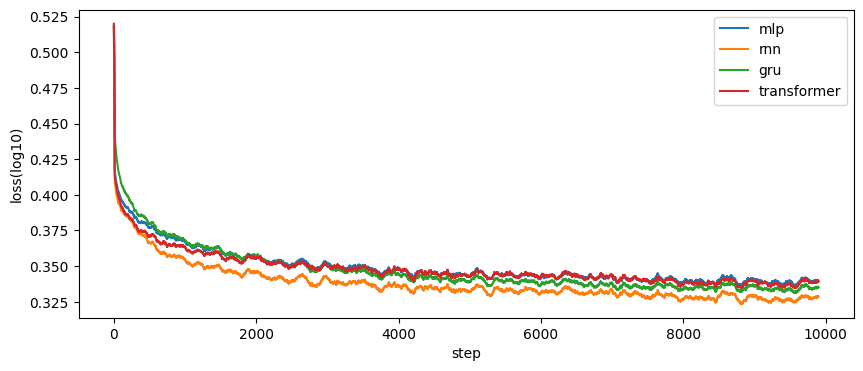

In [63]:
import matplotlib.pyplot as plt

def avg_loss(losses, window=100):
    ini_loss = losses[:10]
    avg_loss = losses[10:].unfold(0, window, 1).mean(1)
    return torch.cat([ini_loss, avg_loss]) # first 10 steps are not averaged, otherwise the initial loss is different

lossi = torch.tensor(lossi) if not isinstance(lossi, torch.Tensor) else lossi
log_lossi = lossi.log10()
model_names = list(models.keys())

plt.figure(figsize=(10, 4))
for i in range(log_lossi.shape[1]):
    plt.plot(avg_loss(log_lossi[:, i]), label=f'{model_names[i]}')
plt.xlabel('step')
plt.ylabel('loss(log10)')
plt.legend()
plt.show()



